# Porto Serguo Safe Driver Prediction

>Project lead: Samuel Madden</br>
Project Contributors: Charles Frank, Ryan Hartford

>Notebook created by: Samuel Madden</br>
Notebook created on: 08/19/19

## Summary
Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

Build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.

#### Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. <a id="given">Values of -1 indicate that the feature was missing from the observation.</a> The target columns signifies whether or not a claim was filed for that policy holder.

#### File descriptions

train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
test.csv contains the test data.

## Contents
1. [Cleaning & Visualization](#cv)</br>
    1.1 [NoteBook Setup](#lib)</br>
    1.2 [AWS Communication](#aws)</br>
    1.3 [Visualize with MissingNo](#msno)</br>
    1.4 [Mean Imputation](#mean)</br>
    1.5 [Visualizing Bias](#bias)</br>
    1.5 [Scaling](#scale)
    

<a id="cv"></a>
## 1. &nbsp; Cleaning & Visualization

<a id="cv"></a>
### 1.1 &nbsp;Notebook Setup

Libraries and Version Numbers

In [1]:
# Comment out any packages that arent installed
!pip install missingno

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

# AWS support
import boto3
from sagemaker import get_execution_role

# magic commands
% matplotlib inline

print("Python Version: " + sys.version)
print("Pandas Version: " + pd.__version__)

Python Version: 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
Pandas Version: 0.24.2


### 1.2 &nbsp; AWS Communication

Permissions and Environment Variables

Settup and link AWS services IAM and S3
> Both train.csv and test.csv for the Porto Sergous Safe Driver Prediction dataset have been previously uploaded to an S3 bucket
<a href="https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/rules">source linked here</a>

In [3]:
role = get_execution_role()
bucket ='sagemaker-studio-thaaoml7ipn'

In [4]:
# load in data from S3 bucket
data_key_train = 'data_SafeDriverPrediction/train.csv'
data_location_train = 's3://{}/{}'.format(bucket, data_key_train)
train = pd.read_csv(data_location_train)

data_key_test = 'data_SafeDriverPrediction/test.csv'
data_location_test = 's3://{}/{}'.format(bucket, data_key_test)
test = pd.read_csv(data_location_test)

# View summary and number of NULL columns
# View column_names, column_datatypes and column_noo (Number Of Observations) 

<a id="msno"></a>
### 1.3 &nbsp; Visualize with MissingNo

> No instance of null values</br>
[Values of -1 indicate that the feature was missing from the observation](#given)

In [5]:
# Create working copies of train and test data, in the instance that an orginal is needed
# Documentation of dataset(located 1.1) observes all NaN entries are input as -1
train_df = train.replace(-1, np.NaN)
test_df = test.replace(-1, np.NaN)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

 >Missing values become apparent: instances less than 595212 </br>
 Notable: ps_reg_03, ps_car_03_cat, ps_car_05_cat

>Highlight missing values by column

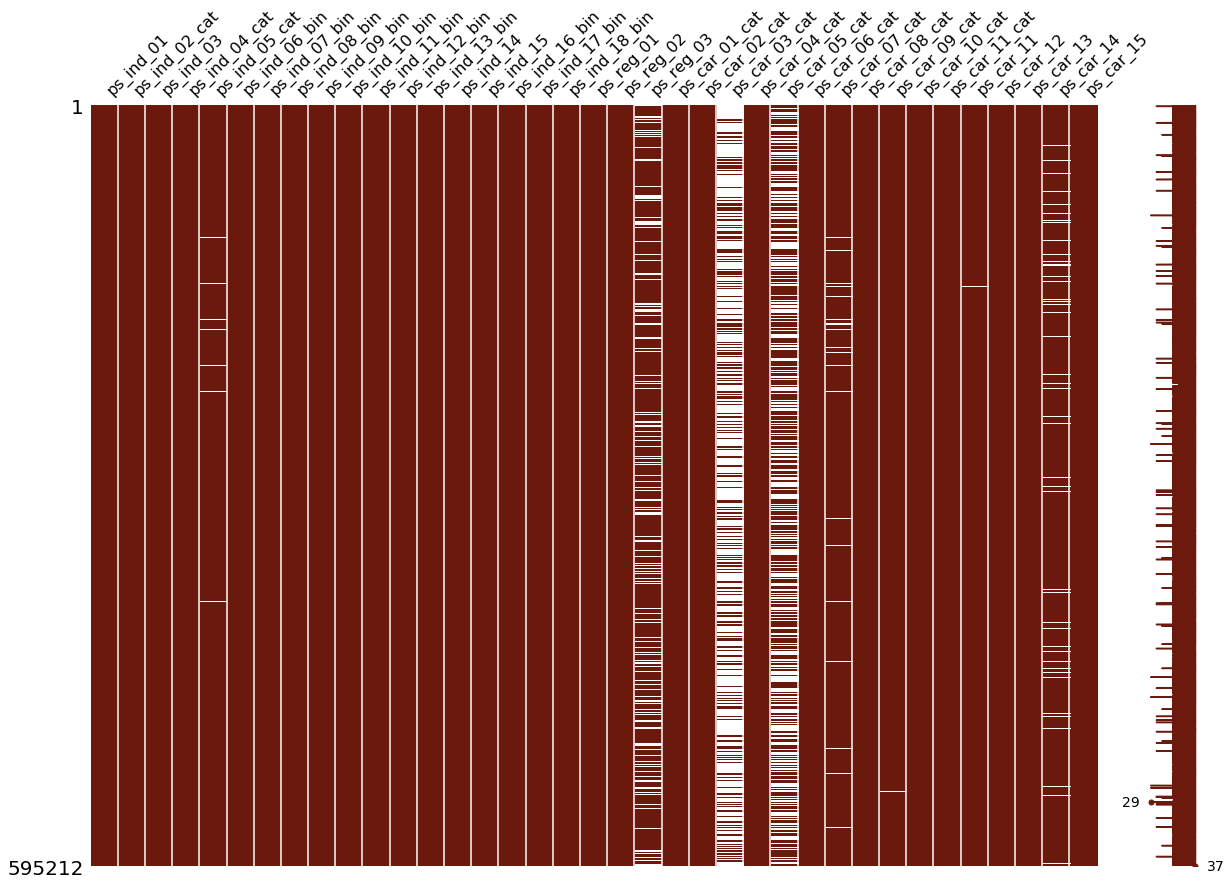

In [6]:
# remember number of instances(observations) in the partitioned data
num_rows_train = train_df.shape[0]

num_rows_test = test_df.shape[0]

msno.matrix(df=train_df.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))
plt.show()
#
#msno.matrix(df=test_df.iloc[:,2:38], figsize=(20, 14), color=(0.42, 0.1, 0.05))
#plt.show()

>Drop columns: ps_reg_03, ps_car_03_cat, ps_car_05_cat

In [8]:
train_df = train_df.drop(['ps_reg_03', 'ps_car_03_cat', 'ps_car_05_cat'], axis=1)
test_df = test_df.drop(['ps_reg_03', 'ps_car_03_cat', 'ps_car_05_cat'], axis=1)

<a id="mean"></a>
### 1.4 &nbsp; Mean Imputation
Replace remaining missing values with mean of respective column

In [9]:
from sklearn.impute import SimpleImputer 

>save column labels in string array

In [10]:
# store names of columns as list for ease of use
col_names_train = list(train_df.columns.values)
col_names_test = list(test_df.columns.values)

In [11]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
# training set
imr_train = imr.fit(train_df)
imputed_trainset = imr.transform(train_df.values)
# test set
imr_test = imr.fit(test_df)
imputed_testset = imr_test.transform(test_df.values)

>convert current ndarray to dataFrame

In [12]:
cleaned_train = pd.DataFrame(imputed_trainset, columns=col_names_train)
cleaned_train.info()

cleaned_test = pd.DataFrame(imputed_testset, columns=col_names_test)
# cleaned_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 56 columns):
id                595212 non-null float64
target            595212 non-null float64
ps_ind_01         595212 non-null float64
ps_ind_02_cat     595212 non-null float64
ps_ind_03         595212 non-null float64
ps_ind_04_cat     595212 non-null float64
ps_ind_05_cat     595212 non-null float64
ps_ind_06_bin     595212 non-null float64
ps_ind_07_bin     595212 non-null float64
ps_ind_08_bin     595212 non-null float64
ps_ind_09_bin     595212 non-null float64
ps_ind_10_bin     595212 non-null float64
ps_ind_11_bin     595212 non-null float64
ps_ind_12_bin     595212 non-null float64
ps_ind_13_bin     595212 non-null float64
ps_ind_14         595212 non-null float64
ps_ind_15         595212 non-null float64
ps_ind_16_bin     595212 non-null float64
ps_ind_17_bin     595212 non-null float64
ps_ind_18_bin     595212 non-null float64
ps_reg_01         595212 non-null float64
ps_reg_

In [1]:
# msno.matrix(df=cleaned_train.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))
# plt.show()
#
# msno.matrix(df=cleaned_test.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))
# plt.show()

NameError: name 'msno' is not defined

>Print cleaned training data to config path

<a id="bias"></a>
### 1.5 &nbsp;Visualizing Bias

In [ ]:
#!pip install imblearn
#!pip install -U scikit-learn
from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.countplot(x='target',data = cleaned_train)
plt.title("Balanced Classes")
plt.show()

In [ ]:
pos_df = cleaned_train.loc[cleaned_train['target'] == 1.0,'target']
neg_df = cleaned_train.loc[cleaned_train['target'] == 0.0,'target'].sample(n=pos_df.size,random_state=42)

norm_df = pd.concat([pos_df,neg_df])
# norm is returned as a Series

In [ ]:
norm_df = pd.DataFrame(norm_df,columns = ['target'])
# Transform norm into a df
norm_df.info
plt.figure(figsize=(8, 8))
sns.countplot(x = 'target', data = norm_df)
plt.title("Balanced Classes")
plt.show()
#

<a id="scale"></a>
### 1.6 &nbsp; Scaling Dataset

Bringing features onto the same scale

In [ ]:
#
print(cleaned_train.head(n=10))
print(cleaned_test.head(n=10))

# Standardization
# x_std = (xi - ux) / sx
from sklearn.preprocessing import StandardScaler
# store excluded columns
col_id_target_train = cleaned_train[['id','target']] 
col_id_test = cleaned_test[['id']]
#col_id_target = cleaned_train['id'] # Use with test

# exclude columns = 'id', 'target' from StandardScaler
X_train_puredata = cleaned_train.drop(['id','target'], axis=1) 
X_test_puredata = cleaned_test.drop(['id'], axis=1)

stdsc = StandardScaler()
# fit using training data
X_train_std_num = stdsc.fit_transform(X_train_puredata)
# use fit parameters to transform the test set
X_test_std_num = stdsc.transform(X_test_puredata)
# turn returned np.arrays back into DataFrame
X_train_std = pd.DataFrame(X_train_std_num, columns=col_names_train[2:])
X_test_std = pd.DataFrame(X_test_std_num, columns=col_names_test[1:])

X_train_std = pd.concat([col_id_target_train['id'],X_train_std], axis=1)
Y_train_std = col_id_target_train['target']
X_test_std = pd.concat([col_id_test, X_test_std], axis=1)

print(X_train_std.head(n=10))

In [ ]:
X_train_std.to_csv("../data", na_rep="NaN", index=False)
#cleaned_train.to_csv(config["cleaned_test_filepath"], na_rep="NaN", index=False)
Y_train_std.to_csv("../data", na_rep="NaN", index=False)
X_test_std.to_csv("../data", na_rep="NaN", index=False)

